<a href="https://colab.research.google.com/github/rahul-t-p/Outdoor-semanticSegmentation/blob/master/outdoor_semantic_segmenation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloads

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%%capture
!unrar x drive/My\ Drive/my_dataset_resize.rar

# Data Preparations

In [0]:
from tqdm.autonotebook import tqdm
import time

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
from PIL import Image
import cv2


import time
import os
import copy

plt.ion()   # interactive mode


In [0]:
img_augmentation = transforms.Compose([
        # transforms.Resize((350, 525)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])       
    ])

mask_augmentation = transforms.Compose([
        # albu.Resize(350, 525)
    ])


In [0]:
class SunDataset(Dataset):
    def __init__(self):
        self.image_folder = "my_dataset_resize/JPEGImages/"
        self.mask_folder = "my_dataset_resize/SegmentationClass/"

        self.transforms = transforms

        self.imgs = list(sorted(os.listdir(self.image_folder)))
        self.masks = list(sorted(os.listdir(self.mask_folder)))


    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder, self.imgs[idx])
        mask_path = os.path.join(self.mask_folder, self.masks[idx])

        img = Image.open(image_path)
        img = img_augmentation(img)
        mask = cv2.imread(mask_path,0)
        # mask = torch.nn.functional.one_hot(torch.from_numpy(mask), 21)
        
        return img, torch.as_tensor(mask)

    def __len__(self):
        return len(self.imgs)

In [0]:
dataset = SunDataset()

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
valid_dataset = torch.utils.data.Subset(dataset, indices[-100:])
train_dataset = torch.utils.data.Subset(dataset, indices[:-100])

In [0]:
len(dataset)

728

In [0]:
train_dataset[0]

(tensor([[[-0.3712, -0.2342, -0.0287,  ...,  0.3309,  0.6221,  0.4679],
          [ 0.3309,  0.0056, -0.2171,  ...,  0.2453,  0.2796,  0.6906],
          [ 0.7762,  0.5364,  0.2967,  ...,  0.8276,  1.1015,  0.4337],
          ...,
          [-0.0116, -0.1143, -0.0116,  ...,  0.4679, -0.2342, -0.8335],
          [-0.5082, -0.2684,  0.0741,  ...,  0.8618,  0.0227, -0.2342],
          [-0.7479, -0.3712, -0.1486,  ...,  0.4851, -0.0116,  0.0912]],
 
         [[-0.0049,  0.1352,  0.3452,  ...,  0.6604,  0.9580,  0.8004],
          [ 0.7129,  0.3803,  0.1527,  ...,  0.6078,  0.6429,  1.0630],
          [ 1.1681,  0.9230,  0.6779,  ...,  1.2031,  1.4832,  0.8004],
          ...,
          [ 0.5728,  0.4678,  0.5028,  ...,  1.1681,  0.4328, -0.1975],
          [ 0.1001,  0.3102,  0.5903,  ...,  1.6232,  0.6954,  0.4328],
          [-0.1450,  0.1877,  0.3627,  ...,  1.2381,  0.7129,  0.8004]],
 
         [[-0.8458, -0.7064, -0.5147,  ...,  0.1476,  0.4439,  0.2696],
          [-0.1312, -0.4798,

In [0]:
num_workers = 0
bs = 8

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

# Model

In [0]:
""" DeepLabv3 Model download and change the head for your prediction"""
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models
from torch import nn
def createDeepLabv3(outputchannels=1):
    model = models.segmentation.deeplabv3_resnet101(
        pretrained=True, progress=True)
    # Added a Sigmoid activation after the last convolution layer
    model.classifier = DeepLabHead(2048, outputchannels)
    # model.classifier = nn.Sigmoid()(DeepLabHead(2048, outputchannels))
    # Set the model in training mode
    return model

In [0]:
model = createDeepLabv3(21)
model.cuda()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:09<00:00, 18.4MB/s]
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:04<00:00, 60.1MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

# Training

In [0]:
num_epochs = 100

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = torch.nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
train_losses = []
valid_losses = []
best_loss = np.Inf

log_dir = "drive/My Drive/"

In [0]:
start_ts = time.time()
for epoch in range(num_epochs):
    train_loss = 0.0

    # progress bar (works in Jupyter notebook too!)
    progress = tqdm(enumerate(train_loader), desc="Train_loss: ", total=len(train_loader))

    # ----------------- TRAINING  -------------------- 
    # set model to training
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        # training step for single batch
        model.zero_grad()
        optimizer.zero_grad()
        outputs = model(X)['out']
        outputs = nn.Sigmoid()(outputs)
        loss = criterion(outputs, y.long())
        loss.backward()
        optimizer.step()

        # getting training quality data
        train_loss += loss.item()

        # updating progress bar
        progress.set_description("Train_loss: {:.4f}".format(train_loss/(i+1)))
        
    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # ----------------- VALIDATION  ----------------- 
    valid_loss = 0.0
    progress = tqdm(enumerate(valid_loader), desc="Valid_loss:", total=len(valid_loader))
    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in progress:
            X, y = data[0].to(device), data[1].to(device)

            outputs = model(X)['out'] # this get's the prediction from the network
            outputs = nn.Sigmoid()(outputs)
            
            valid_loss += criterion(outputs, y.long())

            progress.set_description("Valid_loss: {:.4f}".format(valid_loss/(i+1)))

    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, training loss: {train_loss}, validation loss: {valid_loss}")

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if valid_loss <= best_loss:

        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        best_loss, valid_loss))
        torch.save(model.state_dict(), log_dir+'checkpoint.pth')
        best_loss = valid_loss
    
    print('- '*50)

print(f"Training time: {time.time()-start_ts}s")


Epoch 1/100, training loss: 2.5933691851700407, validation loss: 2.5937564373016357
Validation loss decreased (inf --> 2.593756).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 2/100, training loss: 2.535338480261308, validation loss: 2.5401477813720703
Validation loss decreased (2.593756 --> 2.540148).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 3/100, training loss: 2.5068784786176077, validation loss: 2.498418092727661
Validation loss decreased (2.540148 --> 2.498418).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 4/100, training loss: 2.472375736960882, validation loss: 2.4864699840545654
Validation loss decreased (2.498418 --> 2.486470).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 5/100, training loss: 2.4497623051269146, validation loss: 2.473555088043213
Validation loss decreased (2.486470 --> 2.473555).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 6/100, training loss: 2.449668863151647, validation loss: 2.494020938873291
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 7/100, training loss: 2.435810309422167, validation loss: 2.4762628078460693
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 8/100, training loss: 2.4150307087958613, validation loss: 2.426217555999756
Validation loss decreased (2.473555 --> 2.426218).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 9/100, training loss: 2.405538070050976, validation loss: 2.4345619678497314
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 10/100, training loss: 2.3822380591042434, validation loss: 2.3908798694610596
Validation loss decreased (2.426218 --> 2.390880).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 11/100, training loss: 2.3915307250203965, validation loss: 2.4146971702575684
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 12/100, training loss: 2.372925951511045, validation loss: 2.3817923069000244
Validation loss decreased (2.390880 --> 2.381792).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 13/100, training loss: 2.3730973382539386, validation loss: 2.378812789916992
Validation loss decreased (2.381792 --> 2.378813).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 14/100, training loss: 2.3634361858609356, validation loss: 2.409468173980713
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 15/100, training loss: 2.3591672861123385, validation loss: 2.4839389324188232
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 16/100, training loss: 2.3541783290573313, validation loss: 2.378483533859253
Validation loss decreased (2.378813 --> 2.378484).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 17/100, training loss: 2.338392972946167, validation loss: 2.4336705207824707
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 18/100, training loss: 2.3481937209262123, validation loss: 2.41055965423584
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 19/100, training loss: 2.3179693946355506, validation loss: 2.348628044128418
Validation loss decreased (2.378484 --> 2.348628).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 20/100, training loss: 2.3249213544628287, validation loss: 2.380007028579712
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 21/100, training loss: 2.3067751715454876, validation loss: 2.3366329669952393
Validation loss decreased (2.348628 --> 2.336633).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 22/100, training loss: 2.3128987173490887, validation loss: 2.374752998352051
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 23/100, training loss: 2.308320320105251, validation loss: 2.347095489501953
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 24/100, training loss: 2.3045688761940486, validation loss: 2.4152021408081055
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 25/100, training loss: 2.3074270622639714, validation loss: 2.388617753982544
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 26/100, training loss: 2.3086005554923528, validation loss: 2.328537940979004
Validation loss decreased (2.336633 --> 2.328538).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 27/100, training loss: 2.2982264772246155, validation loss: 2.319448232650757
Validation loss decreased (2.328538 --> 2.319448).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 28/100, training loss: 2.2881098155733905, validation loss: 2.316044807434082
Validation loss decreased (2.319448 --> 2.316045).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 29/100, training loss: 2.295259593408319, validation loss: 2.3235034942626953
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 30/100, training loss: 2.2821885211558284, validation loss: 2.3059587478637695
Validation loss decreased (2.316045 --> 2.305959).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 31/100, training loss: 2.2755362263208703, validation loss: 2.350964069366455
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 32/100, training loss: 2.2779666321187078, validation loss: 2.3074448108673096
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 33/100, training loss: 2.2645275683342656, validation loss: 2.3042526245117188
Validation loss decreased (2.305959 --> 2.304253).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 34/100, training loss: 2.267760044411768, validation loss: 2.3421719074249268
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 35/100, training loss: 2.2635441973239563, validation loss: 2.3250300884246826
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 36/100, training loss: 2.2670076919507376, validation loss: 2.3007636070251465
Validation loss decreased (2.304253 --> 2.300764).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 37/100, training loss: 2.270246804515018, validation loss: 2.3221492767333984
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 38/100, training loss: 2.2609568547598924, validation loss: 2.330029010772705
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 39/100, training loss: 2.2571245024475872, validation loss: 2.3473706245422363
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 40/100, training loss: 2.257820808434788, validation loss: 2.3282439708709717
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 41/100, training loss: 2.2523613217510756, validation loss: 2.318535327911377
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 42/100, training loss: 2.239300398886958, validation loss: 2.3454036712646484
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 43/100, training loss: 2.239609425580954, validation loss: 2.319650650024414
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 44/100, training loss: 2.2490082451059847, validation loss: 2.3290188312530518
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 45/100, training loss: 2.235822662522521, validation loss: 2.2974865436553955
Validation loss decreased (2.300764 --> 2.297487).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 46/100, training loss: 2.2401609420776367, validation loss: 2.301102638244629
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 47/100, training loss: 2.243986341017711, validation loss: 2.306743621826172
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 48/100, training loss: 2.2397594753699965, validation loss: 2.3133835792541504
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 49/100, training loss: 2.2329697216613384, validation loss: 2.346733808517456
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 50/100, training loss: 2.239249374293074, validation loss: 2.295548439025879
Validation loss decreased (2.297487 --> 2.295548).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 51/100, training loss: 2.2343871352038804, validation loss: 2.323765516281128
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 52/100, training loss: 2.2293549066857445, validation loss: 2.3187928199768066
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 53/100, training loss: 2.2331004112581665, validation loss: 2.334872245788574
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 54/100, training loss: 2.2270432152325594, validation loss: 2.30460786819458
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 55/100, training loss: 2.226240873336792, validation loss: 2.314176082611084
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 56/100, training loss: 2.2211601854879643, validation loss: 2.3087410926818848
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 57/100, training loss: 2.213148521471627, validation loss: 2.286180257797241
Validation loss decreased (2.295548 --> 2.286180).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 58/100, training loss: 2.2049357468568824, validation loss: 2.2880358695983887
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 59/100, training loss: 2.203695119181766, validation loss: 2.2932257652282715
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 60/100, training loss: 2.2063729431055767, validation loss: 2.319985866546631
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 61/100, training loss: 2.2140212662612337, validation loss: 2.3011374473571777
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 62/100, training loss: 2.2189457778689228, validation loss: 2.2975480556488037
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 63/100, training loss: 2.2203374271151386, validation loss: 2.3018014430999756
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 64/100, training loss: 2.2105618639837337, validation loss: 2.321355104446411
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 65/100, training loss: 2.211908008478865, validation loss: 2.3414924144744873
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 66/100, training loss: 2.212326710737204, validation loss: 2.2856640815734863
Validation loss decreased (2.286180 --> 2.285664).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 67/100, training loss: 2.202540168279334, validation loss: 2.2983129024505615
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 68/100, training loss: 2.200685739517212, validation loss: 2.304387331008911
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 69/100, training loss: 2.215220167667051, validation loss: 2.3383524417877197
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 70/100, training loss: 2.2067671486094027, validation loss: 2.3180434703826904
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 71/100, training loss: 2.215704727776443, validation loss: 2.330275297164917
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 72/100, training loss: 2.197074769418451, validation loss: 2.2846546173095703
Validation loss decreased (2.285664 --> 2.284655).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 73/100, training loss: 2.2020692583880845, validation loss: 2.303697347640991
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 74/100, training loss: 2.199134283427951, validation loss: 2.305358648300171
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 75/100, training loss: 2.1946784665312946, validation loss: 2.314122200012207
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 76/100, training loss: 2.193700874908061, validation loss: 2.294459819793701
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 77/100, training loss: 2.1887717458266245, validation loss: 2.3300442695617676
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 78/100, training loss: 2.1992511688908443, validation loss: 2.316016912460327
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 79/100, training loss: 2.219529191149941, validation loss: 2.312298536300659
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 80/100, training loss: 2.1973136376731004, validation loss: 2.2846436500549316
Validation loss decreased (2.284655 --> 2.284644).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 81/100, training loss: 2.1941098895254014, validation loss: 2.291273832321167
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 82/100, training loss: 2.1933973529670814, validation loss: 2.3026225566864014
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 83/100, training loss: 2.1827421882484535, validation loss: 2.2840676307678223
Validation loss decreased (2.284644 --> 2.284068).  Saving model ...
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 84/100, training loss: 2.1818252032316185, validation loss: 2.2983791828155518
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 85/100, training loss: 2.1811161343055434, validation loss: 2.297319173812866
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 86/100, training loss: 2.1917066121403175, validation loss: 2.3018252849578857
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 87/100, training loss: 2.1816307804252526, validation loss: 2.3092541694641113
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 88/100, training loss: 2.185481720332858, validation loss: 2.299133062362671
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 89/100, training loss: 2.1837408934967426, validation loss: 2.3123440742492676
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 90/100, training loss: 2.188598273675653, validation loss: 2.308542013168335
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 91/100, training loss: 2.1899217985853365, validation loss: 2.330101490020752
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 92/100, training loss: 2.195393468760237, validation loss: 2.299060821533203
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 93/100, training loss: 2.1896123705030996, validation loss: 2.3126938343048096
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 94/100, training loss: 2.1868144681182087, validation loss: 2.3034050464630127
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 95/100, training loss: 2.1754629098916354, validation loss: 2.3174126148223877
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 96/100, training loss: 2.179713716989831, validation loss: 2.304131507873535
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 97/100, training loss: 2.172552621817287, validation loss: 2.306034803390503
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 98/100, training loss: 2.17365187331091, validation loss: 2.322380304336548
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 99/100, training loss: 2.175147174279901, validation loss: 2.284510850906372
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Epoch 100/100, training loss: 2.173622762100606, validation loss: 2.3358564376831055
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training time: 3228.377937555313s


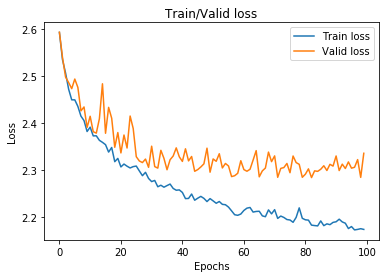

In [0]:
%matplotlib inline

plt.plot(train_losses, label='Train loss')
plt.plot(valid_losses, label='Valid loss')

plt.title('Train/Valid loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.savefig('traing_progress.png')
plt.show()

# Inferences

In [0]:
labels = {0:'background', 1:'beach', 2:'building', 3:'cat', 4:'desert', 5:'dog',
          6:'field', 7:'flower', 8:'ground', 9:'horse', 10:'house', 11:'lake', 12:'mountain',
          13:'plants', 14:'road', 15:'rock', 16:'sea', 17:'shrubs', 18:'sky',
          19:'snowfield', 20:'trees'}

In [0]:
model.load_state_dict(torch.load(log_dir+'checkpoint.pth'))

<All keys matched successfully>

In [0]:
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [0]:
img, mask = valid_dataset[50]

In [0]:
img.shape

torch.Size([3, 128, 128])

In [0]:
img = img[None,:,:,:]
print(img.shape)
outputs = model(img.to(device))['out']
outputs = nn.Sigmoid()(outputs).squeeze()

torch.Size([1, 3, 128, 128])


In [0]:
outputs.shape

torch.Size([21, 128, 128])

In [0]:
pred = torch.argmax(outputs,dim=0).detach().cpu().numpy()

In [0]:
pred

array([[18, 18, 18, ..., 18, 18, 18],
       [18, 18, 18, ..., 18, 18, 18],
       [18, 18, 18, ..., 18, 18, 18],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6]])

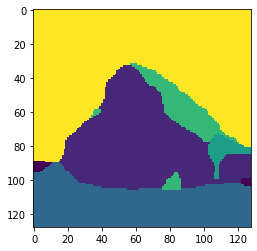

In [0]:
import matplotlib.pyplot as plt
plt.imshow(pred)

In [0]:
target = mask.detach().cpu().numpy()

In [0]:
target

array([[ 0,  0,  0, ...,  0,  0,  0],
       [18, 18, 18, ..., 18, 18, 18],
       [18, 18, 18, ..., 18, 18, 18],
       ...,
       [ 0,  8,  8, ...,  8,  8,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

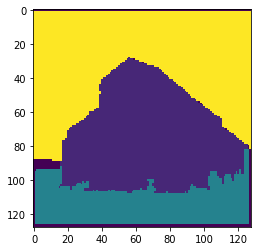

In [0]:
plt.imshow(target)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


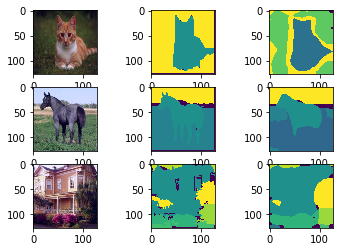

In [0]:
import matplotlib.pyplot as plt
import random

mean = np.array([0.456, 0.406, 0.485])
std = np.array([0.224, 0.225, 0.229])

num=331
k=0

for i in range(3):
    rnd_id=random.randint(0,500)
    img, mask = train_dataset[rnd_id]
    img = img[None,:,:,:]
    outputs = model(img.to(device))['out']
    outputs = nn.Sigmoid()(outputs).squeeze()
    pred = torch.argmax(outputs,dim=0).detach().cpu().numpy()
    target = mask.detach().cpu().numpy()

    img, _ = train_dataset[rnd_id]
    img = img.permute(1, 2, 0).numpy()
    img = img * std
    img = img + mean
    plt.subplot(str(num+3*i))
    plt.imshow(img)
    plt.subplot(str(num+3*i+1))
    plt.imshow(target)
    plt.subplot(str(num+3*i+2))
    plt.imshow(pred)
    plt.savefig('sample.png')